## Hay que hacer una autenticacion al principio

In [1]:
#desautenticando:
import ee
ee.Reset()  # limpia cualquier sesión previa


In [2]:
import ee
ee.Authenticate(
    authorization_code=None,
    scopes=[
        'https://www.googleapis.com/auth/earthengine',
        'https://www.googleapis.com/auth/devstorage.full_control',
        'https://www.googleapis.com/auth/drive'
    ],
    quiet=False,
    auth_mode='notebook'
)
ee.Initialize()


In [3]:
print(ee.Image("ECMWF/ERA5_LAND/DAILY_AGGR/20210101").bandNames().getInfo())


['dewpoint_temperature_2m', 'temperature_2m', 'skin_temperature', 'soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3', 'soil_temperature_level_4', 'lake_bottom_temperature', 'lake_ice_depth', 'lake_ice_temperature', 'lake_mix_layer_depth', 'lake_mix_layer_temperature', 'lake_shape_factor', 'lake_total_layer_temperature', 'snow_albedo', 'snow_cover', 'snow_density', 'snow_depth', 'snow_depth_water_equivalent', 'snowfall_sum', 'snowmelt_sum', 'temperature_of_snow_layer', 'skin_reservoir_content', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4', 'forecast_albedo', 'surface_latent_heat_flux_sum', 'surface_net_solar_radiation_sum', 'surface_net_thermal_radiation_sum', 'surface_sensible_heat_flux_sum', 'surface_solar_radiation_downwards_sum', 'surface_thermal_radiation_downwards_sum', 'evaporation_from_bare_soil_sum', 'evaporation_from_open_water_surfaces_excluding_oceans_sum', '

## Verificando que se me haya dado acceso

In [4]:
import ee

ee.Initialize()

# Probar accediendo a un dataset simple
dataset = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR').first()
print(dataset.getInfo())


{'type': 'Image', 'bands': [{'id': 'dewpoint_temperature_2m', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [3601, 1801], 'crs': 'EPSG:4326', 'crs_transform': [0.1, 0, -180.05, 0, -0.1, 90.05]}, {'id': 'temperature_2m', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [3601, 1801], 'crs': 'EPSG:4326', 'crs_transform': [0.1, 0, -180.05, 0, -0.1, 90.05]}, {'id': 'skin_temperature', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [3601, 1801], 'crs': 'EPSG:4326', 'crs_transform': [0.1, 0, -180.05, 0, -0.1, 90.05]}, {'id': 'soil_temperature_level_1', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [3601, 1801], 'crs': 'EPSG:4326', 'crs_transform': [0.1, 0, -180.05, 0, -0.1, 90.05]}, {'id': 'soil_temperature_level_2', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [3601, 1801], 'crs': 'EPSG:4326', 'crs_transform': [0.1, 0, -180.05, 0, -0.1, 90.05]}, {'id': 'soil_tem

In [12]:
# --- Instalaciones (solo si no las tenés) ---
# pip install earthengine-api geemap pandas

import ee
import pandas as pd
from datetime import datetime

# Inicializar Earth Engine
ee.Initialize()

# --- Coordenadas de Bahía Blanca ---
bahiablanca = ee.Geometry.Point([-62.2683, -38.7196])

# --- Variables ---
variables = [
    # 🌧️ Precipitación
    'total_precipitation_sum',
    'snowmelt_sum',
    'snowfall_sum',

    # 🌊 Escorrentía y acumulación de agua
    'runoff_sum',
    'surface_runoff_sum',
    'sub_surface_runoff_sum',
    'total_evaporation_sum',

    # 💧 Contenido de agua en el suelo
    'volumetric_soil_water_layer_1',
    'volumetric_soil_water_layer_2',

    # 🌤️ Radiación y evaporación
    'surface_net_solar_radiation_sum',
    'surface_thermal_radiation_downwards_sum',
    'surface_latent_heat_flux_sum',

    # 🌡️ Temperatura del aire y superficie
    'temperature_2m',
    'skin_temperature',
    'soil_temperature_level_1',
    'temperature_2m_min',
    'temperature_2m_max',

    # 🌬️ Viento y presión
    'dewpoint_temperature_2m',
    'surface_solar_radiation_downwards_sum',
    'surface_pressure',
    'u_component_of_wind_10m',
    'v_component_of_wind_10m'
]

# --- Función para obtener valores diarios en el punto ---
def extract_daily_values(image):
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=bahiablanca,
        scale=1000
    )
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    feature = ee.Feature(None, mean_dict.set('date', date))
    return feature

# --- Función para procesar un rango de fechas ---
def get_data_for_period(start_date, end_date):
    print(f"📅 Procesando {start_date} → {end_date}...")
    dataset = (
        ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")
        .filterDate(start_date, end_date)
        .select(variables)
    )

    features = dataset.map(extract_daily_values)
    data = features.getInfo()['features']

    rows = []
    for f in data:
        props = f['properties']
        props['localidad'] = 'Bahía Blanca'
        props['lat_lon'] = '-38.7196, -62.2683'
        rows.append(props)

    return pd.DataFrame(rows)

# --- Loop por períodos (10 años cada uno) ---
periods = [
    ('1940-01-01', '1950-01-01'),
    ('1950-01-01', '1960-01-01'),
    ('1960-01-01', '1970-01-01'),
    ('1970-01-01', '1980-01-01'),
    ('1980-01-01', '1990-01-01'),
    ('1990-01-01', '2000-01-01'),
    ('2000-01-01', '2010-01-01'),
    ('2010-01-01', '2016-01-01'),
]

# --- Descargar y concatenar todo ---
all_dataframes = []

for start, end in periods:
    df_part = get_data_for_period(start, end)
    all_dataframes.append(df_part)

df_full = pd.concat(all_dataframes, ignore_index=True)

# --- Guardar el CSV final ---
df_full.to_csv('bahia_blanca_era5.csv', index=False, encoding='utf-8')

print("✅ CSV final creado con éxito: bahia_blanca_era5.csv")
print(f"📊 Total de filas: {len(df_full)}")


📅 Procesando 1940-01-01 → 1950-01-01...
📅 Procesando 1950-01-01 → 1960-01-01...
📅 Procesando 1960-01-01 → 1970-01-01...
📅 Procesando 1970-01-01 → 1980-01-01...
📅 Procesando 1980-01-01 → 1990-01-01...
📅 Procesando 1990-01-01 → 2000-01-01...
📅 Procesando 2000-01-01 → 2010-01-01...
📅 Procesando 2010-01-01 → 2016-01-01...
✅ CSV final creado con éxito: bahia_blanca_era5.csv
📊 Total de filas: 24105


In [16]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24105 entries, 0 to 24104
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   date                                     24105 non-null  object 
 1   dewpoint_temperature_2m                  24105 non-null  float64
 2   runoff_sum                               24105 non-null  float64
 3   skin_temperature                         24105 non-null  float64
 4   snowfall_sum                             24105 non-null  float64
 5   snowmelt_sum                             24105 non-null  float64
 6   soil_temperature_level_1                 24105 non-null  float64
 7   sub_surface_runoff_sum                   24105 non-null  float64
 8   surface_latent_heat_flux_sum             24105 non-null  int64  
 9   surface_net_solar_radiation_sum          24105 non-null  float64
 10  surface_pressure                         24105

C:\Users\COMPU\AppData\Local\Temp\ipykernel_8804\79905406.py:26: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\COMPU\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


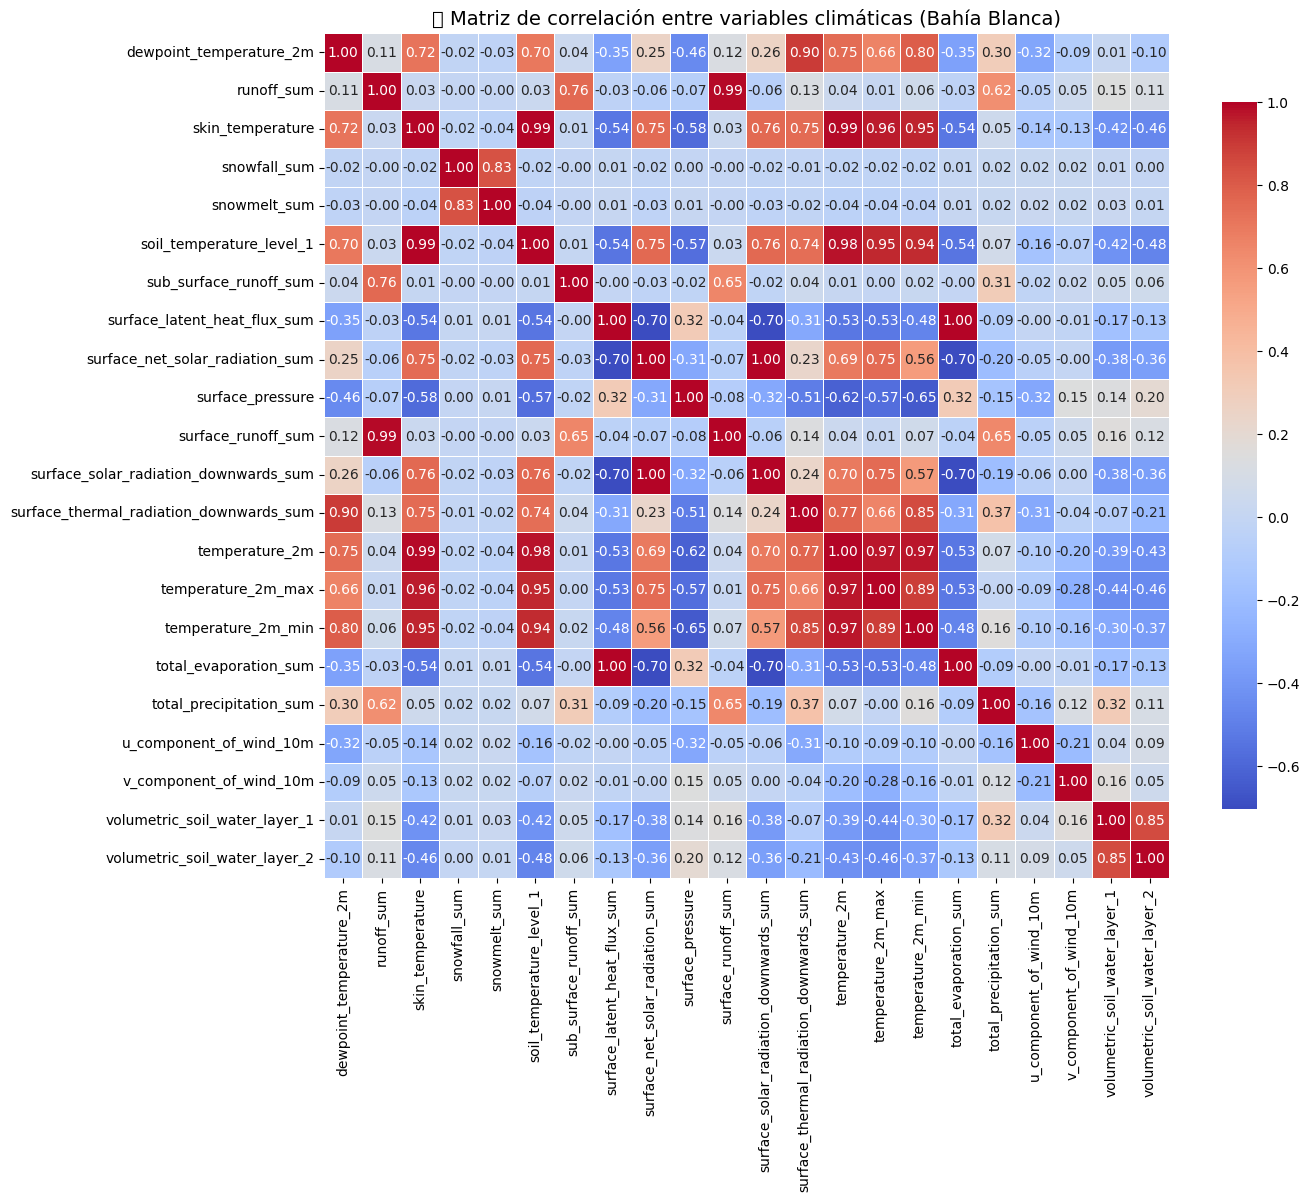

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar tu CSV
df = pd.read_csv("bahia_blanca_era5.csv")

# Solo variables numéricas
num_df = df.select_dtypes(include=['float64', 'int64'])

# Calcular matriz de correlación
corr_matrix = num_df.corr()

# Crear el heatmap con anotaciones
plt.figure(figsize=(14,12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',      # azul-negativo, rojo-positivo
    annot=True,           # muestra los números
    fmt=".2f",            # dos decimales
    linewidths=0.5,       # separadores finos
    square=True,          # hace los cuadros más parejos
    cbar_kws={'shrink': 0.8}  # barra de color más compacta
)
plt.title("🔍 Matriz de correlación entre variables climáticas (Bahía Blanca)", fontsize=14)
plt.tight_layout()
plt.show()
